In [99]:
%matplotlib notebook

from decimal import *
import math

from pprint import pprint
import json

import boto3
import requests

import pandas as pd
import numpy as np

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [25]:
# Always ensure that project imports are fresh by reloading the modules
# WARNING: Do not use this technique for modules who are dependencies of other modules, THERE WILL BE BUGS!!
import sys
from importlib import reload

# Make sure that the symbols exist first
from utils.aws_fargate_price_calculator import AWSFargatePriceCalculator
from utils.aws_lambda_price_calculator import AWSLambdaPriceCalculator

# Then reload for subsequent executions of this cell
AWSFargatePriceCalculator = reload(sys.modules['utils.aws_fargate_price_calculator']).AWSFargatePriceCalculator
AWSLambdaPriceCalculator = reload(sys.modules['utils.aws_lambda_price_calculator']).AWSLambdaPriceCalculator

In [26]:
fargate_calc = AWSFargatePriceCalculator('us-west-1')

In [4]:
fargate_calc.calculate_cost(
    os_type='linux-x86',
    num_cpu=1,
    num_gb_ram=2,
    num_gb_storage=20,
    time=60 * 10
)

{'total-cost': Decimal('0.009906666666666666666666666669'),
 'cpu-cost': Decimal('0.007760000000000000000000000002'),
 'memory-cost': Decimal('0.001703333333333333333333333334'),
 'os-license-cost': Decimal('0E-28'),
 'storage-cost': Decimal('0.0004433333333333333333333333334')}

In [5]:
fargate_calc.calculate_cost(
    os_type='linux-x86',
    num_cpu=1,
    num_gb_ram=2,
    num_gb_storage=20,
    time=60 * 10,
    spot=True
)

{'total-cost': Decimal('0.003282333333333333333333333333'),
 'cpu-cost': Decimal('0.002328000000000000000000000000'),
 'memory-cost': Decimal('0.0005110000000000000000000000001'),
 'os-license-cost': Decimal('0'),
 'storage-cost': Decimal('0.0004433333333333333333333333334')}

In [6]:
fargate_calc.calculate_savings(
    os_type='linux-x86',
    num_cpu=1,
    num_gb_ram=2,
    num_gb_storage=20,
    time=60 * 10
)

{'total-cost-savings': Decimal('66.86742934051144010767160163'),
 'cpu-cost-savings': Decimal('70.00000000000000000000000001'),
 'memory-cost-savings': Decimal('70.00000000000000000000000001'),
 'os-license-cost-savings': nan,
 'storage-cost-savings': Decimal('0')}

In [7]:
lambda_calc = AWSLambdaPriceCalculator('us-west-1')

In [8]:
lambda_calc.calculate_simple_function_cost('linux-x86', 1.5, 120 / 1000, 3_000_000, free_usage=True)

{'total-cost': Decimal('2.733337999999999666932426480'),
 'duration-cost': Decimal('2.333337999999999666932426480'),
 'requests-cost': Decimal('0.4000000000')}

In [9]:
lambda_calc.calculate_simple_function_cost('linux-x86', 1, 2, 7_440_000)

{'total-cost': Decimal('249.4884960000'),
 'duration-cost': Decimal('248.0004960000'),
 'requests-cost': Decimal('1.4880000000')}

In [10]:
lambda_calc.calculate_concurrent_function_cost('linux-x86', 1.5, 100 / 1000, 500_000, 100, 28_800)

1.14430E-8


{'total-cost': Decimal('22.14393700000000004764105777'),
 'duration-cost': Decimal('0.8582250000000000476410577654'),
 'requests-cost': Decimal('0.1000000000'),
 'concurrency-cost': Decimal('21.18571200000')}

In [11]:
lambda_calc.calculate_edge_function_cost(1 / 8, 10 / 1000, 10_000_000)

{'total-cost': Decimal('6.625125000000000013013028155'),
 'duration-cost': Decimal('0.6251250000000000130130281552'),
 'requests-cost': Decimal('6.0000000000')}

# Comparing between (default) Fargate and (default) Lambda prices

In [151]:
all_supported_memory = [value for value in fargate_calc.get_all_supported_memory() if value <= 10]

def _internal_fargate_lambda_cost_analysis(num_gb_ram, time, requests, free_lambda_usage):
    # Get optimal vCPUs for given memory configuration
    optimal_num_cpus = -1
    for (num_cpus, memory_vals) in fargate_calc.get_supported_memory().items():
        # If it can't be found, it'll throw an 'invalid configuration error' 
        if num_gb_ram in memory_vals:
            optimal_num_cpus = num_cpus
    
    # Do Fargate price calculations
    fargate_prices = fargate_calc.calculate_cost(
        os_type='linux-x86',
        num_cpu=optimal_num_cpus,
        num_gb_ram=num_gb_ram,
        num_gb_storage=20,
        time=time,
        # Free usage refers to the 20 GB of free storage, so it's enabled by default
        free_usage=True
    )
    
    # Do Lambda price calculations
    lambda_prices = lambda_calc.calculate_simple_function_cost(
        os_type='linux-x86',
        num_gb_ram=num_gb_ram,
        time=time,
        requests=requests,
        # Free usage refers to the 400k GB-s of free duration and 1M free requests, so it's a toggleable option
        free_usage=free_lambda_usage
    )
    
    return fargate_prices, lambda_prices
    
    print(fargate_prices['total-cost'])
    print(lambda_prices['total-cost'])

@interact(
    num_gb_ram=widgets.SelectionSlider(
        options=all_supported_memory,
        description='Memory (GB):',
        disabled=False,
        continuous_update=True,
        orientation='horizontal',
        readout=True,
        readout_format='d',
        style={'description_width': 'initial'}
    ),
    time=widgets.FloatSlider(
        value=300,
        min=0,
        max=15 * 60,
        step=5,
        description='Time (s):',
        disabled=False,
        continuous_update=True,
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
        style={'description_width': 'initial'}
    ),
    requests=widgets.FloatSlider(
        value=1,
        min=0,
        max=1000,
        step=5,
        description='# of Requests (10k):',
        disabled=False,
        continuous_update=True,
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
        style={'description_width': 'initial'}
    ),
    free_lambda_usage=widgets.Checkbox(
        value=False,
        description='Lambda Free Tier?',
        disabled=False,
        indent=False,
        style={'description_width': 'initial'}
    )
)
def interactive_fargate_lambda_cost_analysis(num_gb_ram, time, requests, free_lambda_usage):
    fargate_prices, lambda_prices = _internal_fargate_lambda_cost_analysis(
        num_gb_ram, time, requests * 10_000, free_lambda_usage
    )
    
    print('Fargate cost: $%.5f' % (fargate_prices['total-cost']))
    print(' Lambda cost: $%.5f' % (lambda_prices['total-cost']))
    print()
    print('Full Fargate costs')
    pprint(fargate_prices)
    print()
    print('Full Lambda costs')
    pprint(lambda_prices)

interactive(children=(SelectionSlider(description='Memory (GB):', options=(0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)…

<IPython.core.display.Javascript object>


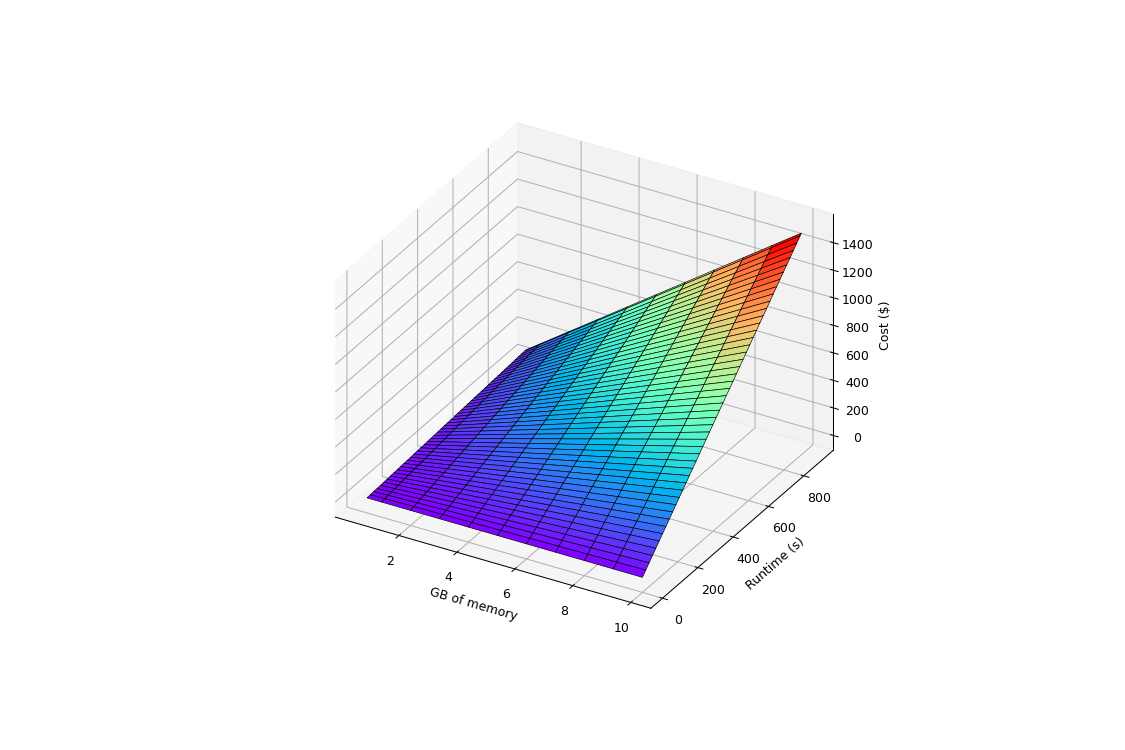

Text(0.5, 0, 'Cost ($)')

In [149]:
# This graph shows how much more money AWS Lambda costs compared to its equivalent
# Fargate configuration, using 10krequests and no Lambda free tier

# Source for 3D graph code: https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html
x_arr = all_supported_memory
y_arr = list(range(0, 15 * 60 + 1, 1))

X, Y = np.meshgrid(x_arr, y_arr)
Z = np.zeros(X.shape)

for (i, x) in enumerate(x_arr):
    for (j, y) in enumerate(y_arr):
        fargate_prices, lambda_prices = _internal_fargate_lambda_cost_analysis(x, y, 10_000, False)
        Z[j, i] = lambda_prices['total-cost'] - fargate_prices['total-cost']

fig = plt.figure()
fig.set_dpi(150)
ax = plt.axes(projection='3d', proj_type='ortho')
ax.plot_surface(X, Y, Z, cmap='rainbow', edgecolor='black', linewidth=0.5)
ax.set_xlabel('GB of memory')
ax.set_ylabel('Runtime (s)')
ax.set_zlabel('Cost ($)')